In [1]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, \
    Concatenate
from keras.losses import mean_squared_error

In [3]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True, as_supervised=True)
train_A, train_B = dataset['trainA'], dataset['trainB']
test_A, test_B = dataset['testA'], dataset['testB']







Shuffling and writing examples to /home/methodfunc/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKIPZ6Q/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /home/methodfunc/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKIPZ6Q/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /home/methodfunc/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKIPZ6Q/cycle_gan-testA.tfrecord
Shuffling and writing examples to /home/methodfunc/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKIPZ6Q/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /home/methodfunc/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0. Subsequent calls will reuse this data.


In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

In [6]:
train_A = train_A.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B = train_B.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A = test_A.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B = test_B.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
inpA = next(iter(train_A))
inpB = next(iter(train_B))

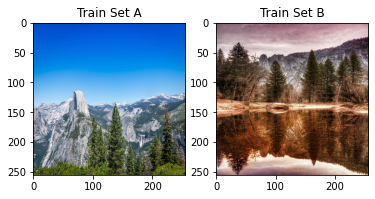

In [8]:
plt.subplot(121)
plt.title('Train Set A')
plt.imshow(inpA[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Train Set B')
plt.imshow(inpB[0] * 0.5 + 0.5)

In [9]:
def downsample(filters, size=3, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential([
        Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    ])

    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())

    return result

In [10]:
def upsample(filters, size=3, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential([
        Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    ])

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [11]:
class ResnetIdentityBlock(Model):
    def __init__(self, kernel_size, filters):
        super(ResnetIdentityBlock, self).__init__(name='')
        filters1, filters2, filters3 = filters

        self.conv2a = Conv2D(filters1, (1, 1))
        self.bn2a = BatchNormalization()

        self.conv2b = Conv2D(filters2, kernel_size=kernel_size, padding='same')
        self.bn2b = BatchNormalization()

        self.conv2c = Conv2D(filters3, (1, 1))
        self.bn2c = BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

In [12]:
block1 = ResnetIdentityBlock(3, [512, 512, 512])
block2 = ResnetIdentityBlock(3, [512, 512, 512])
block3 = ResnetIdentityBlock(3, [512, 512, 512])

resnet = [block1, block2, block3]

print(block1(tf.zeros([1, 16, 16, 512])).shape)
print([x.name for x in block1.trainable_variables])

(1, 16, 16, 512)
['resnet_identity_block/conv2d/kernel:0', 'resnet_identity_block/conv2d/bias:0', 'resnet_identity_block/batch_normalization/gamma:0', 'resnet_identity_block/batch_normalization/beta:0', 'resnet_identity_block/conv2d_1/kernel:0', 'resnet_identity_block/conv2d_1/bias:0', 'resnet_identity_block/batch_normalization_1/gamma:0', 'resnet_identity_block/batch_normalization_1/beta:0', 'resnet_identity_block/conv2d_2/kernel:0', 'resnet_identity_block/conv2d_2/bias:0', 'resnet_identity_block/batch_normalization_2/gamma:0', 'resnet_identity_block/batch_normalization_2/beta:0']


In [13]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    inputs = Input(shape=[256, 256, 3])
    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    for block in resnet:
        x = block(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        concat = Concatenate()
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [14]:
generator = Generator()
keras.utils.plot_model(generator, '../result/images/generator.png', show_shapes=True)

generator.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None,

In [15]:
def Discriminator():
    inputs = Input(shape=[None, None, 3])
    x = inputs
    g_filter = 64

    down_stack = [
        downsample(g_filter),
        downsample(g_filter * 2),
        downsample(g_filter * 4),
        downsample(g_filter * 8),
    ]

    for down in down_stack:
        x = down(x)

    last = Conv2D(1, 4, strides=1, padding='same')
    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [16]:
discriminator_A = Discriminator()
discriminator_B = Discriminator()

generator_AB = Generator()
generator_BA = Generator()

loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
@tf.function
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generator_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generator_loss

    return total_disc_loss

optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)

valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32')
fake = np.zeros((BATCH_SIZE, 16, 16, 1)).astype('float32')

In [18]:
@tf.function
def train_batch(imgs_A, imgs_B):
    with tf.GradientTape() as g, tf.GradientTape() as d_tape:
        fake_B = generator_AB(imgs_A, training=True)
        fake_A = generator_AB(imgs_B, training=True)

        logits_real_A = discriminator_A(imgs_A, training = True)
        logits_fake_A = discriminator_A(fake_A, training = True)
        dA_loss = discriminator_loss(logits_real_A, logits_fake_A)

        logits_real_B = discriminator_B(imgs_B, training=True)
        logits_fake_B = discriminator_B(fake_B, training=True)
        dB_loss = discriminator_loss(logits_real_B, logits_fake_B)
        d_loss = (dA_loss + dB_loss) / 2

        reconstr_A = generator_BA(fake_B, training=True)
        reconstr_B = generator_AB(fake_A, training=True)

        id_A = generator_BA(imgs_A, training=True)
        id_B = generator_AB(imgs_B, training=True)

        gen_loss = tf.math.reduce_sum([
            1 * tf.math.reduce_mean(mean_squared_error(logits_fake_A, valid)),
            1 * tf.math.reduce_mean(mean_squared_error(logits_fake_B, valid)),
            10 * tf.math.reduce_mean(mean_squared_error(reconstr_A, imgs_A)),
            10 * tf.math.reduce_mean(mean_squared_error(reconstr_B, imgs_B)),
            0.1 * tf.math.reduce_mean(mean_squared_error(id_A, imgs_A)),
            0.1 * tf.math.reduce_mean(mean_squared_error(id_B, imgs_B))
        ])

        gradients_of_d = d_tape.gradient(d_loss, discriminator_A.trainable_variables + discriminator_B.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_d, discriminator_A.trainable_variables + discriminator_B.trainable_variables))

        gradients_of_generator = g.gradient(gen_loss, generator_AB.trainable_variables + generator_BA.trainable_variables)
        optimizer.apply_gradients(zip(gradients_of_generator, generator_AB.trainable_variables + generator_BA.trainable_variables))

        return dA_loss, dB_loss, gen_loss

In [19]:
checkpoint_dird_A = '../result/training_checkpointed_A'
checkpoint_prefixd_A = os.path.join(checkpoint_dird_A, "ckpt_{epoch}")

checkpoint_dird_B = '../result/training_checkpointed_B'
checkpoint_prefixd_B = os.path.join(checkpoint_dird_B, "ckpt_{epoch}")

checkpoint_dird_AB = '../result/training_checkpointed_AB'
checkpoint_prefixd_AB = os.path.join(checkpoint_dird_AB, "ckpt_{epoch}")

checkpoint_dird_BA = '../result/training_checkpointed_BA'
checkpoint_prefixd_BA = os.path.join(checkpoint_dird_BA, "ckpt_{epoch}")

In [20]:
def train(trainA_, trainB_, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch_i, (imgs_A, imgs_B) in enumerate(zip(trainA_, trainB_)):
            dA_loss, dB_loss, g_loss = train_batch(imgs_A, imgs_B)

            if batch_i % 1000 == 0:
                test_imgA = next(iter(test_A))
                test_imgB = next(iter(test_B))
                print('Time taken for epoch {} batch index {} is {} seconds\n'.format(epoch, batch_i, time.time()-start))
                print('discriminator A : ', dA_loss.numpy())
                print('discriminator B : ', dB_loss.numpy())
                print('generator: {}\n'.format(g_loss))

                fig, axs = plt.subplots(2, 2, figsize = (10, 10), sharey=True, sharex=True)
                gen_outputA = generator_AB(test_imgA, training=False)
                gen_outputB = generator_BA(test_imgB, training=False)
                axs[0, 0].imshow(test_imgA[0]* 0.5 + 0.5)
                axs[0, 0].set_title('Generator A Input')

                axs[0, 1].imshow(gen_outputA[0] * 0.5 + 0.5)
                axs[0, 1].set_title('Generator A Output')

                axs[1, 0].imshow(test_imgB[0] * 0.5 + 0.5)
                axs[1, 0].set_title('Generator B Input')

                axs[1, 1].imshow(gen_outputB[0] * 0.5 + 0.5)
                axs[1, 1].set_title('Generator B Output')
                plt.show()

                discriminator_A.save_weights(checkpoint_prefixd_A.format(epoch=epoch))
                discriminator_B.save_weights(checkpoint_prefixd_B.format(epoch=epoch))
                generator_AB.save_weights(checkpoint_prefixd_AB.format(epoch=epoch))
                generator_BA.save_weights(checkpoint_prefixd_BA.format(epoch=epoch))

Time taken for epoch 0 batch index 0 is 5.829402923583984 seconds

discriminator A :  1.5922146
discriminator B :  1.5716531
generator: 10.013731002807617

Time taken for epoch 1 batch index 0 is 0.1777482032775879 seconds

discriminator A :  1.3799632
discriminator B :  1.1171137
generator: 4.923172950744629

Time taken for epoch 2 batch index 0 is 0.18963837623596191 seconds

discriminator A :  1.1344421
discriminator B :  0.9124168
generator: 6.0060811042785645

Time taken for epoch 3 batch index 0 is 0.19005227088928223 seconds

discriminator A :  1.1050894
discriminator B :  1.2128983
generator: 4.029922008514404

Time taken for epoch 4 batch index 0 is 0.19005894660949707 seconds

discriminator A :  1.316586
discriminator B :  1.1854849
generator: 4.346508502960205

Time taken for epoch 5 batch index 0 is 0.1807107925415039 seconds

discriminator A :  1.2822824
discriminator B :  1.3169672
generator: 3.6460793018341064

Time taken for epoch 6 batch index 0 is 0.18039345741271973 

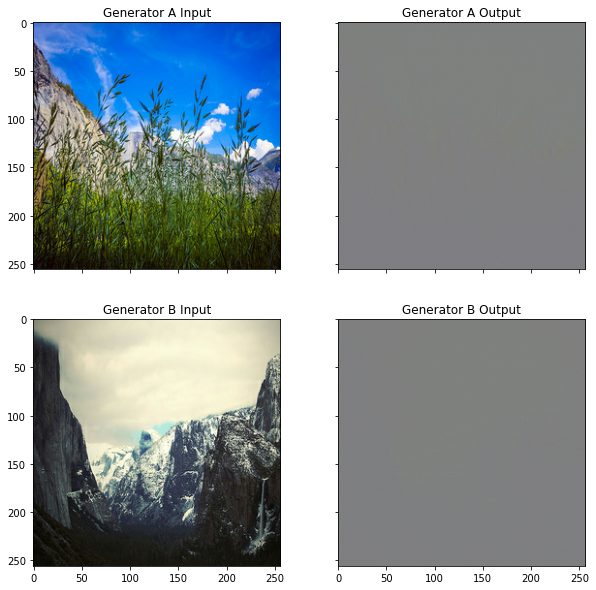

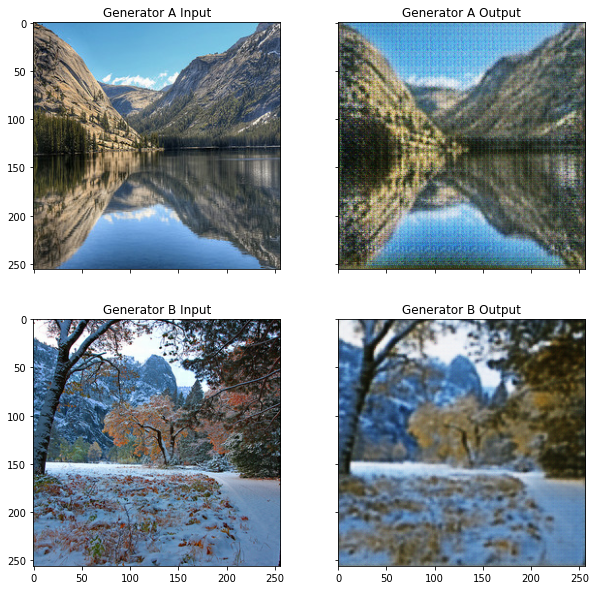

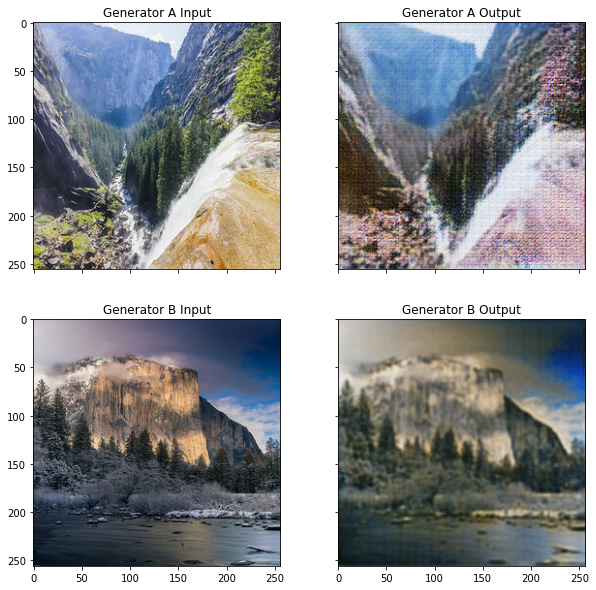

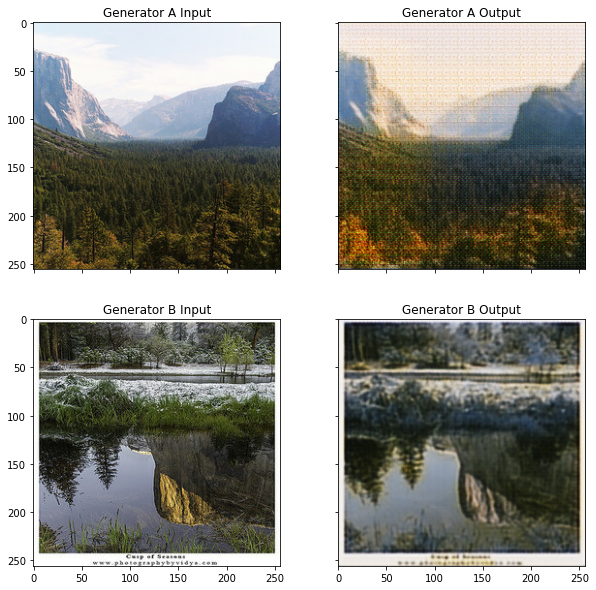

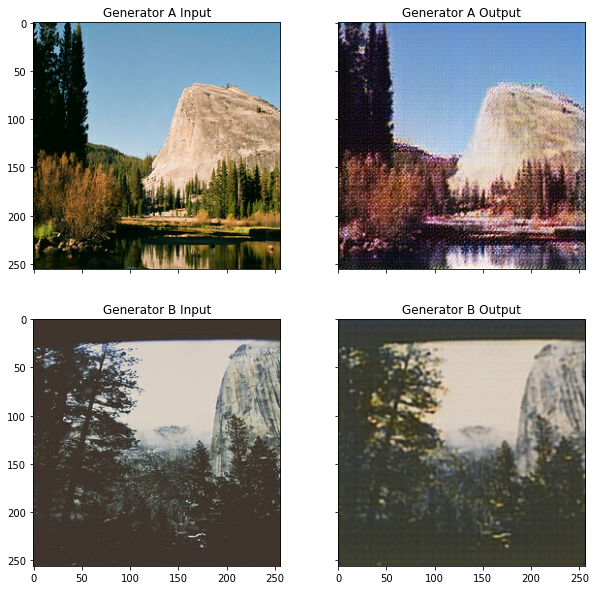

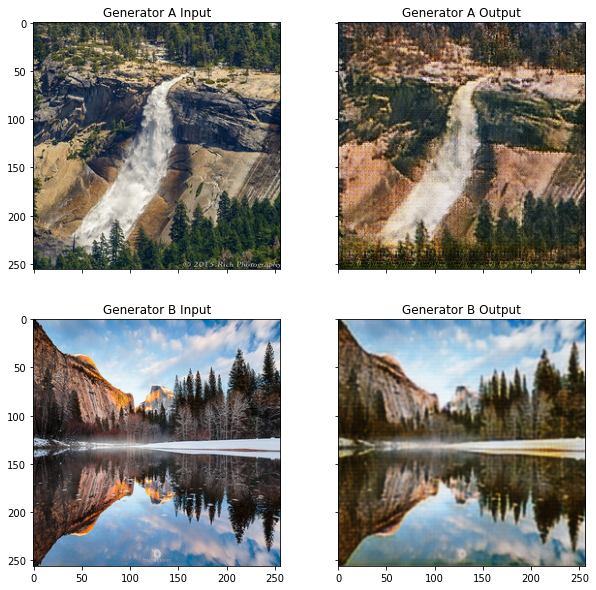

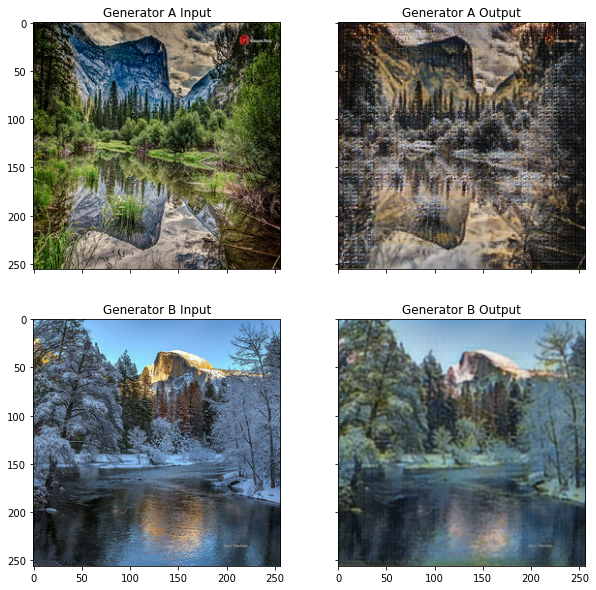

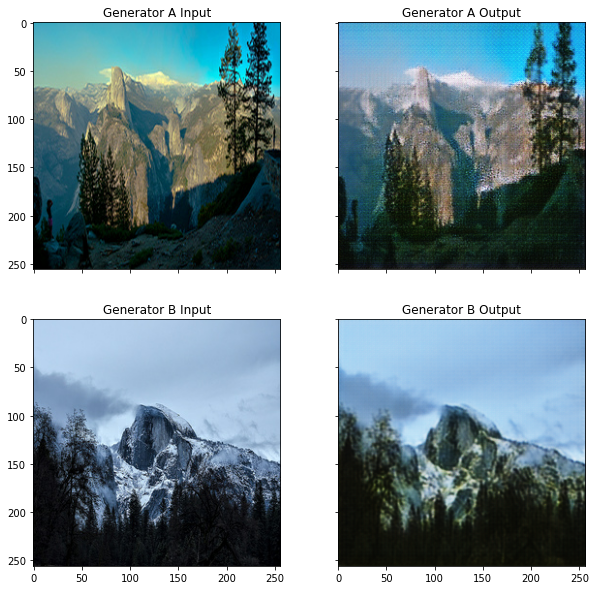

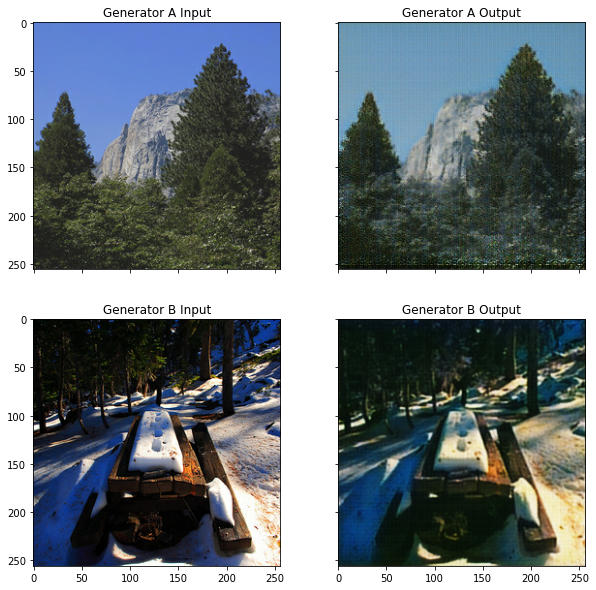

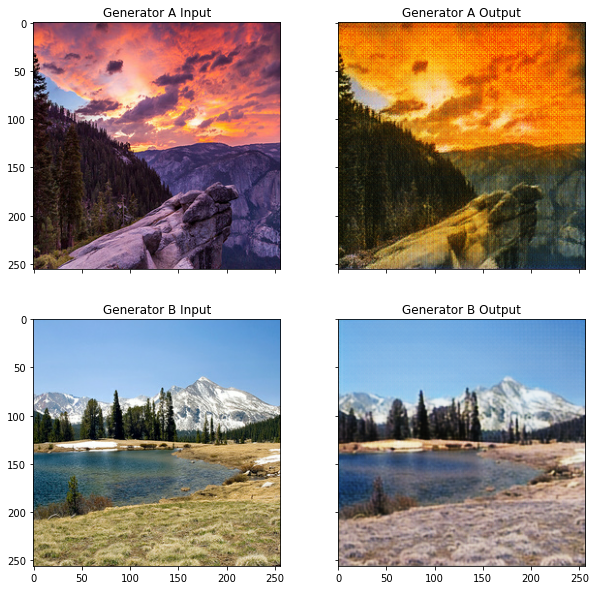

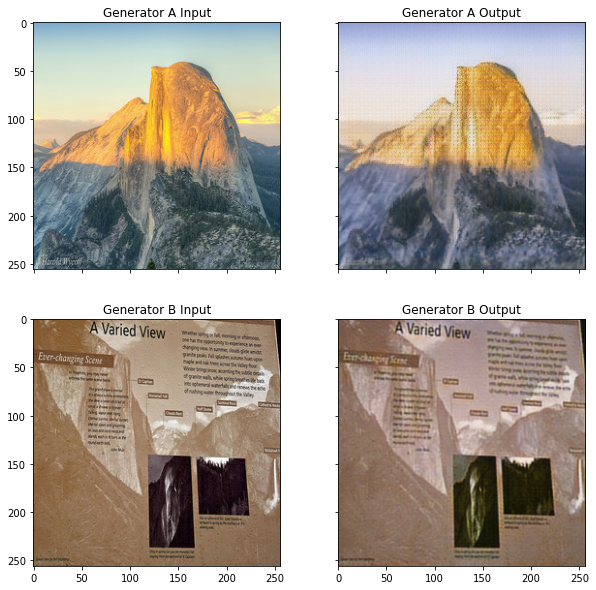

In [ ]:
if __name__ == '__main__':
    train(train_A, train_B, EPOCHS)